In [1]:
import numpy as np
import pandas as pd
from typing import Dict, List
import time;
from datetime import datetime
import duckdb;
import matplotlib.pyplot as plt
# import seaborn as sns
from matplotlib.ticker import FuncFormatter
from gameutils.DataUtil import DataUtil

# 设置中文字体支持
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'DejaVu Sans']  # 按优先级尝试
plt.rcParams['axes.unicode_minus'] = False  # 正确显示负号

# 读取数据
data_util = DataUtil()
result = data_util.getTableData('data/game_analysis_v2.duck', ['dim_role', 'fact_player_login_recharge','fact_player_activity', 'fact_player_activity_detail_sec'])
has_register_df = result["has_register_df"]    #角色表
login_recharge_df = result["login_recharge_df"]  #登录和充值表

# print(f"读取了 {len(result)} 张表")
for table_name, df in result.items():
    print(f"{table_name}: {df.shape}")

LoadData 初始化
dim_role: (373596, 11)
fact_player_login_recharge: (693996, 29)
fact_player_activity: (624112, 26)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

fact_player_activity_detail_sec: (24420071, 39)
有创角的角色数:225954
has_register_df: (225954, 11)
login_recharge_df: (693996, 31)


In [2]:
# 按日期分组
def group_by_date(df: pd.DataFrame, date_column: str = 'first_login_date') -> Dict[str, pd.DataFrame]:
    if date_column not in df.columns:
        print(f"警告: DataFrame 中没有 '{date_column}' 列")
        return;
    
    grouped = df.groupby(df[date_column])
    # print(f"分组键: {grouped.groups}")
    # print(f"分组键名称: {grouped.keys}")
    print(f"分组数量: {grouped.ngroups}")
    return grouped

分组数量: 376
first_login_date
2023-12-14    4117
2023-12-15    3654
2023-12-16    3003
2023-12-17    3883
2023-12-18    6344
dtype: int64
注册用户数大于等于3的日期数量: 80
按日期分组计数:
                  register_count
first_login_date                
2023-12-14                  4117
2023-12-15                  3654
2023-12-16                  3003
2023-12-17                  3883
2023-12-18                  6344


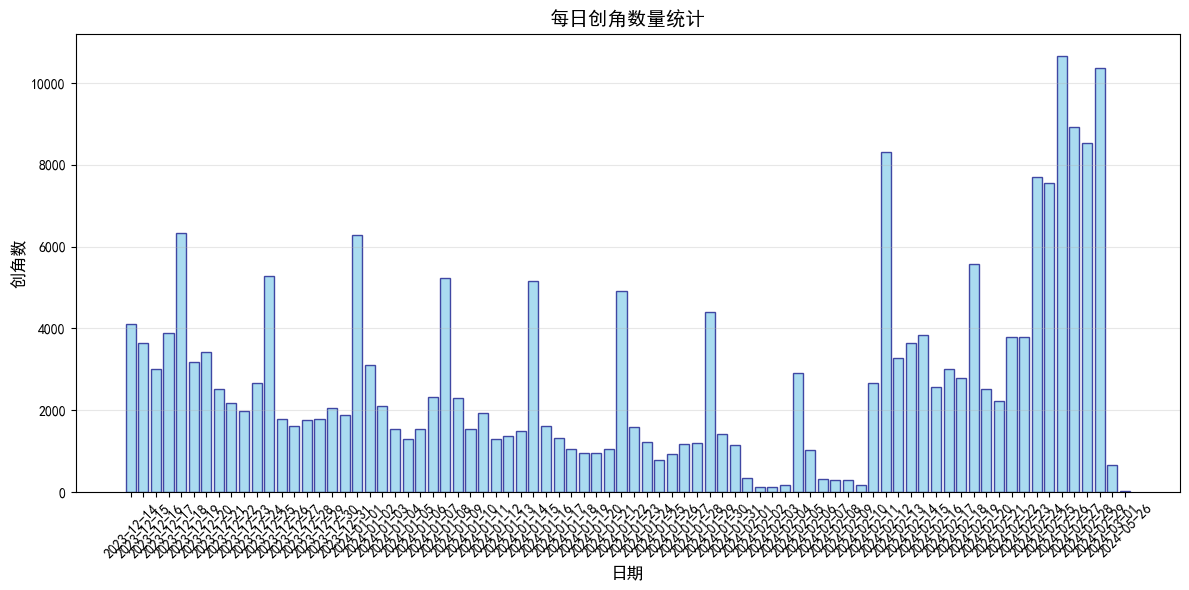

In [3]:
register_date = group_by_date(has_register_df, 'first_login_date')
size_series=register_date.size()
print(size_series.head(5))
filtered_regis = size_series[size_series >= 10]
print(f"注册用户数大于等于3的日期数量: {filtered_regis.count()}")

daily_counts = filtered_regis.to_frame(name='register_count')
print("按日期分组计数:")
print(daily_counts.head(5))

# 绘制基础柱形图

plt.figure(figsize=(12, 6))
plt.bar(daily_counts.index, daily_counts['register_count'], 
        color='skyblue', edgecolor='navy', alpha=0.7)
plt.title('每日创角数量统计', fontsize=14, fontweight='bold')
plt.xlabel('日期', fontsize=12)
plt.ylabel('创角数', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# print("\n每个分组的内容:")
# for name, group in register_date:
#     print(f"\n分组 '{name}':")
#     print(f"数量: {group.count()}")  # 每个group是DataFrame
#     print(group)

In [4]:
#计算留存率
def calRetentionRate(analys_day, data) -> pd.Series:
    filter2=data[data['login_days']<=analys_day]      
    print(f"前{analys_day}天数据:{len(filter2)}")
    grouped = filter2.groupby(['login_days'])

    login_series=grouped.size()
    print(f"每个日期每个天的登录记录数:\n{login_series.head(10)}")

    total_remain = pd.Series()
    for i in range(1,analys_day+1):
        total_remain['remain'+str(i)] = login_series.loc[i] / login_series.loc[1]
    print("\n留存率:")
    print(total_remain)
    return total_remain

# 绘制折线图
def to_percent(x, pos):
    # x：Y轴原始数值，pos：刻度位置（无需使用）
    return f'{x:.1%}'  # .1% 表示保留1位小数的百分比

def plotRetentionRate(total_remain: pd.Series, title: str = '留存率'):
    plt.figure(figsize=(12, 6))
    total_remain.plot(kind='line', 
        grid=True,
        title=title,
        linewidth=2,
        color='red',
        marker='o',
        markersize=4)
    plt.gca().yaxis.set_major_formatter(FuncFormatter(to_percent))       #把y轴格式化为百分比形式
    # plt.yscale('log')  # 设置Y轴为对数刻度
    plt.ylabel('留存率')
    plt.xlabel('天数')
    plt.xticks(rotation=45)  # 旋转x轴标签
    plt.tight_layout()
    plt.show()

In [5]:
print(f"登录登出记录数:{len(login_recharge_df)}")
# 同时选择特定列
login_filter = login_recharge_df.loc[login_recharge_df['login_cnt'] >= 1]     #过滤出登录类型的记录

print(f"登录记录数:{len(login_filter)}")
analys_day=30
login_remain=calRetentionRate(analys_day,login_filter)

登录登出记录数:693996
登录记录数:691270
前30天数据:382473
每个日期每个天的登录记录数:
login_days
1     225954
2      22845
3      13785
4      10838
5       9305
6       8185
7       7394
8       6903
9       6292
10      5627
dtype: int64

留存率:
remain1     1.000000
remain2     0.101105
remain3     0.061008
remain4     0.047966
remain5     0.041181
remain6     0.036224
remain7     0.032723
remain8     0.030550
remain9     0.027846
remain10    0.024903
remain11    0.023155
remain12    0.021557
remain13    0.019885
remain14    0.019008
remain15    0.017397
remain16    0.016052
remain17    0.015207
remain18    0.014707
remain19    0.014193
remain20    0.013299
remain21    0.013069
remain22    0.012600
remain23    0.012166
remain24    0.011710
remain25    0.011440
remain26    0.011157
remain27    0.010918
remain28    0.010790
remain29    0.010511
remain30    0.010374
dtype: float64


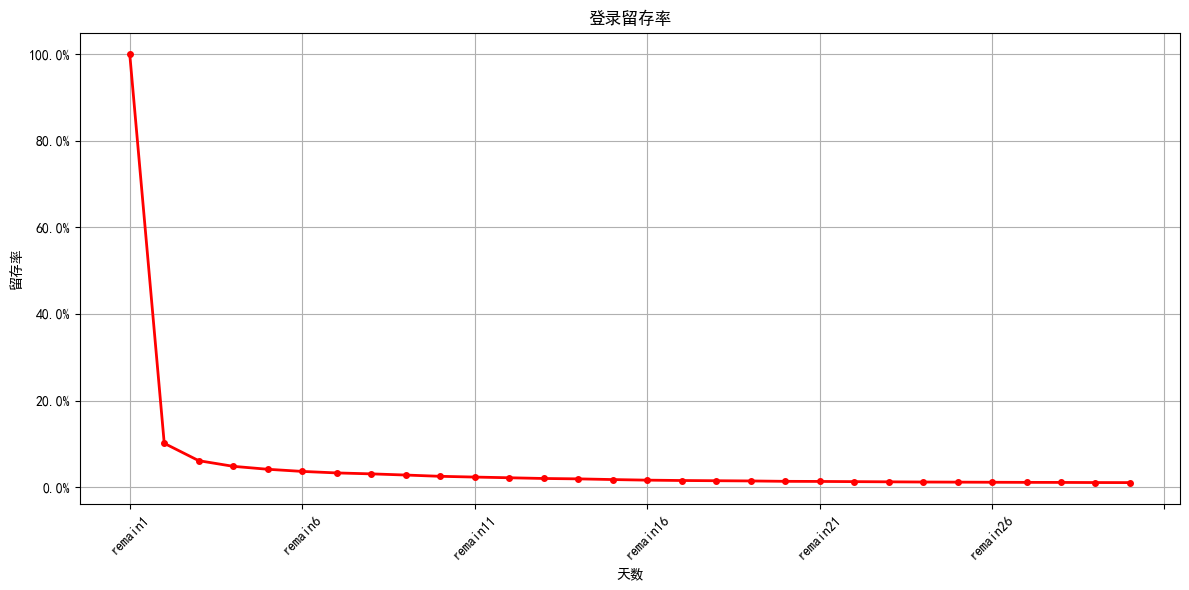

In [6]:
plotRetentionRate(login_remain, '登录留存率')

In [7]:
# 1. 先筛选出满足条件的行（假设条件为：stat_date为1且recharge_amt>0）
recharge_filtered_rows = login_filter[(login_filter['login_days'] == 1) & (login_filter['real_money'] > 0)]
print(f"充值用户数:{len(recharge_filtered_rows)}")

# 2. 获取这些行的 rid 值
matched_rids = recharge_filtered_rows['rid'].unique()  # 使用unique()避免重复
print(f"充值用户RID数:{len(matched_rids)}")

# 3. 从原始数据中找到所有具有这些 rid 值的行
all_rows_with_same_rid = login_filter[login_filter['rid'].isin(matched_rids)]
print(f"与充值用户相同RID的登录记录数:{len(all_rows_with_same_rid)}")

# 4. 如果你想保留原始筛选结果和所有相关行，可以分别保存
recharge_remain=calRetentionRate(analys_day,all_rows_with_same_rid)

充值用户数:8497
充值用户RID数:8497
与充值用户相同RID的登录记录数:183314
前30天数据:62051
每个日期每个天的登录记录数:
login_days
1     8497
2     5892
3     4265
4     3573
5     3083
6     2794
7     2580
8     2427
9     2176
10    1973
dtype: int64

留存率:
remain1     1.000000
remain2     0.693421
remain3     0.501942
remain4     0.420501
remain5     0.362834
remain6     0.328822
remain7     0.303637
remain8     0.285630
remain9     0.256090
remain10    0.232200
remain11    0.215959
remain12    0.201012
remain13    0.187007
remain14    0.177592
remain15    0.170413
remain16    0.163705
remain17    0.155467
remain18    0.151465
remain19    0.146405
remain20    0.138755
remain21    0.136636
remain22    0.131576
remain23    0.127692
remain24    0.123691
remain25    0.120160
remain26    0.117806
remain27    0.115923
remain28    0.114864
remain29    0.110980
remain30    0.110510
dtype: float64


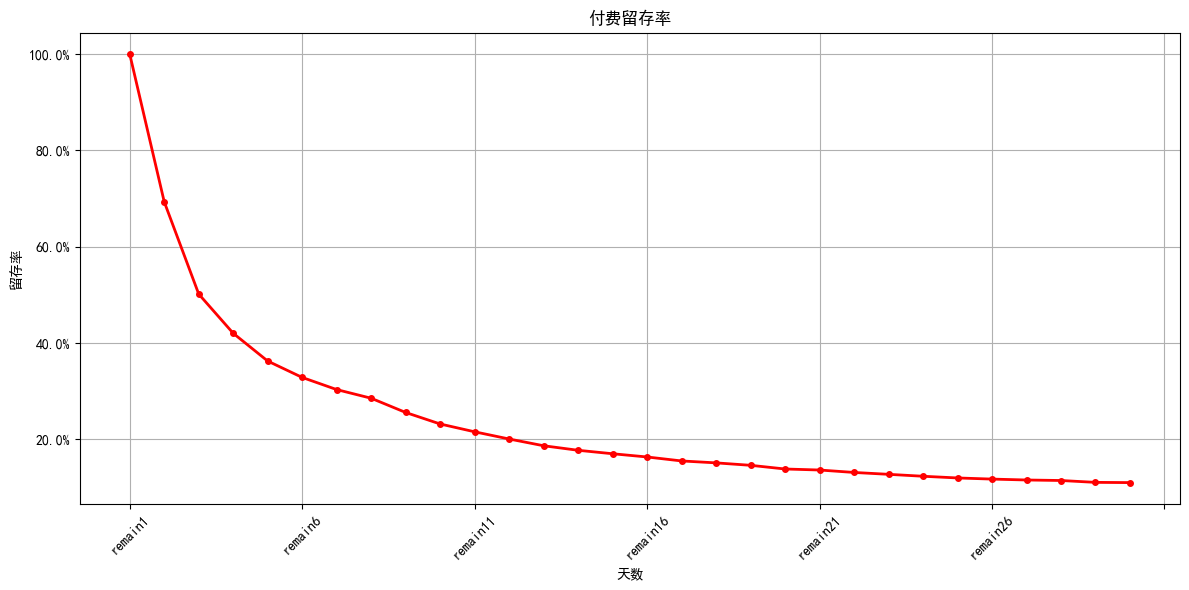

In [8]:
plotRetentionRate(recharge_remain, '付费留存率')

In [9]:
#DAU（日活跃用户数）：当日登录游戏的用户数（需要去重处理，即去除当日同一用户重复登录的情况）
dau_df = login_filter.groupby('stat_date')
dau_size = dau_df.size()
print(dau_size.head(5))

stat_date
2023-12-14    4117
2023-12-15    4320
2023-12-16    3908
2023-12-17    4962
2023-12-18    7795
dtype: int64


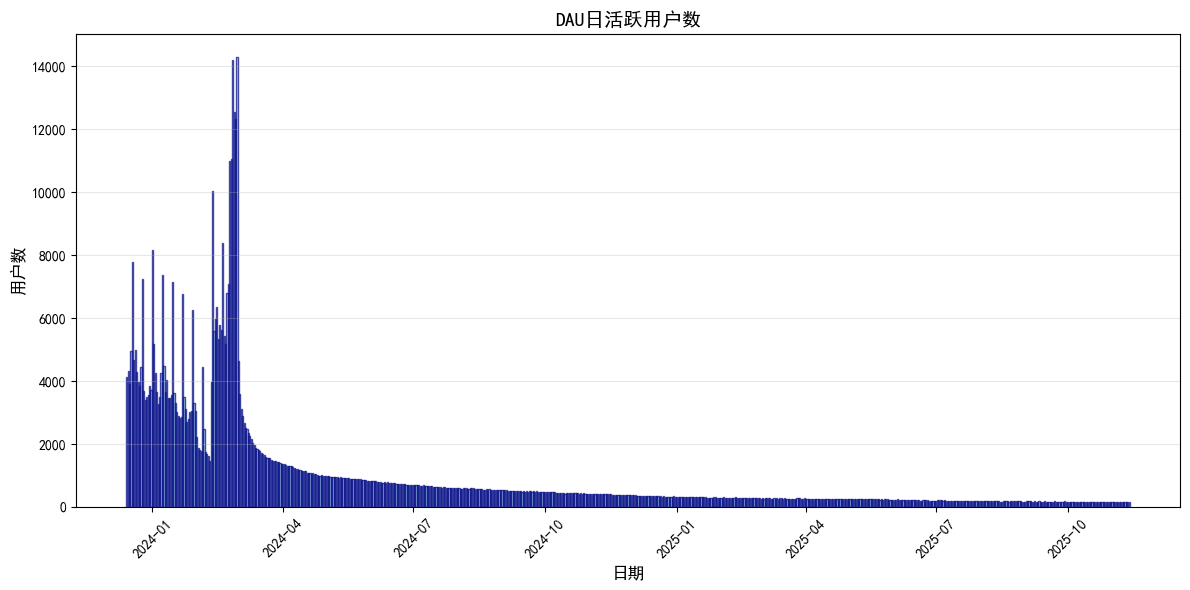

In [10]:
#汇制dau
plt.figure(figsize=(12, 6))
plt.bar(dau_size.index, dau_size.values, 
        color='skyblue', edgecolor='navy', alpha=0.7)
plt.title('DAU日活跃用户数', fontsize=14, fontweight='bold')
plt.xlabel('日期', fontsize=12)
plt.ylabel('用户数', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [11]:
#ARPU（平均每用户收入）：
#ARPU（平均每用户收入）：总收入除以活跃用户数，反映每个用户的平均贡献。
#ARPU=付费金额（收入）/活跃用户数
arpu_df = login_filter.groupby('stat_date').agg({
    'real_money': 'sum',  # 总收入
})
arpu_df['dau'] = dau_size
arpu_df['ARPU'] = arpu_df['real_money'] / arpu_df['dau']
print(arpu_df.head(5))

            real_money   dau      ARPU
stat_date                             
2023-12-14     23188.0  4117  5.632256
2023-12-15     29034.0  4320  6.720833
2023-12-16     32006.0  3908  8.189867
2023-12-17     44468.0  4962  8.961709
2023-12-18     38044.0  7795  4.880564


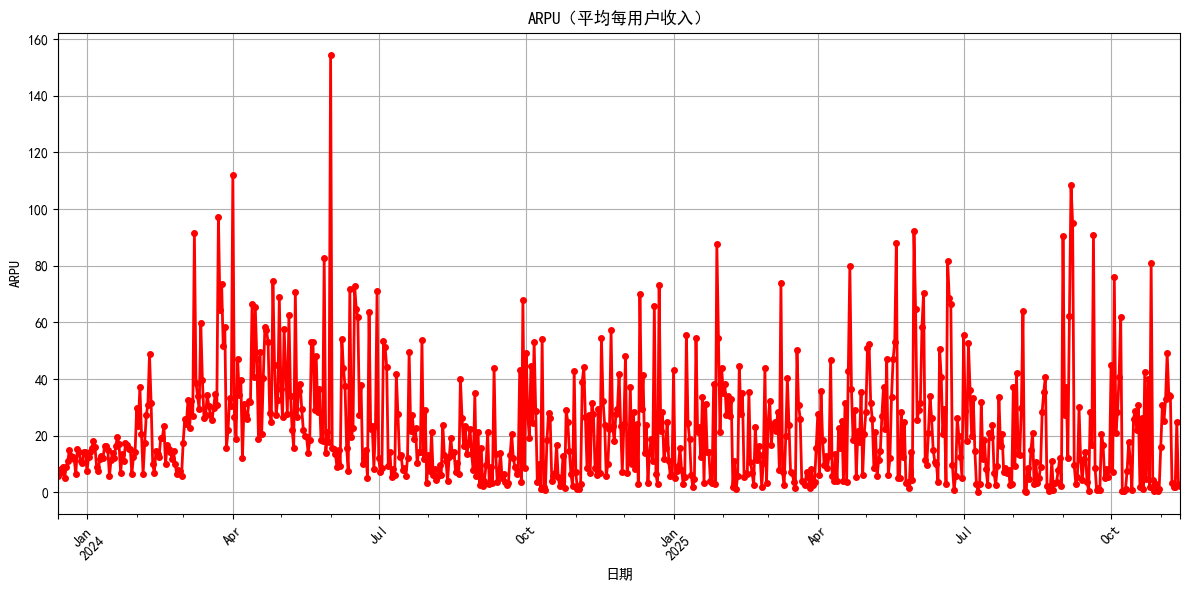

In [12]:
#画出arpu_df中的ARPU列的折线图
plt.figure(figsize=(12, 6))
arpu_df['ARPU'].plot(kind='line', 
grid=True,
title="ARPU（平均每用户收入）",
linewidth=2,
color='red',
marker='o',
markersize=4)
# plt.gca().yaxis.set_major_formatter(FuncFormatter(to_percent))       #把y轴格式化为百分比形式
# plt.yscale('log')  # 设置Y轴为对数刻度
plt.ylabel('ARPU')
plt.xlabel('日期')
plt.xticks(rotation=45)  # 旋转x轴标签
plt.tight_layout()
plt.show()

In [13]:
# ARPPU
# ARPPU，全称 Average Revenue Per Paying User，指付费⽤户的平均收益，传统领域也称作“客单价”，是用来衡量付费玩家在游戏中的付费实力的标准。
# ARPPU=付费金额（收入）/付费用户数
paying_users_df = login_filter[login_filter['real_money'] > 0]
paying_users_grouped = paying_users_df.groupby('stat_date').agg({
    'real_money': 'sum',  # 总收入
})
paying_users_grouped['paying_user_count'] = paying_users_df.groupby('stat_date').size()
paying_users_grouped['ARPPU'] = paying_users_grouped['real_money'] / paying_users_grouped['paying_user_count']
print(paying_users_grouped.head(5))

            real_money  paying_user_count       ARPPU
stat_date                                            
2023-12-14     23188.0                275   84.320000
2023-12-15     29034.0                355   81.785915
2023-12-16     32006.0                346   92.502890
2023-12-17     44468.0                401  110.892768
2023-12-18     38044.0                337  112.890208


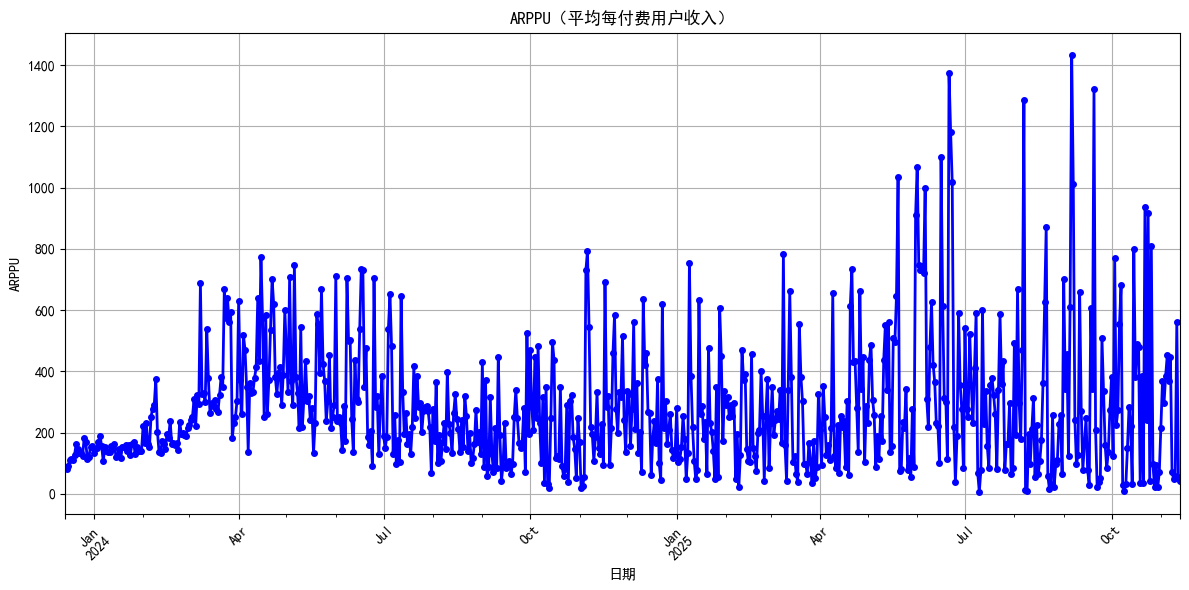

In [14]:
#画出paying_users_grouped中的ARPPU列的折线图
plt.figure(figsize=(12, 6))
paying_users_grouped['ARPPU'].plot(kind='line', 
grid=True,
title="ARPPU（平均每付费用户收入）",
linewidth=2,
color='blue',
marker='o',
markersize=4)
# plt.gca().yaxis.set_major_formatter(FuncFormatter(to_percent))       #把y轴格式化为百分比形式
# plt.yscale('log')  # 设置Y轴为对数刻度
plt.ylabel('ARPPU')
plt.xlabel('日期')
plt.xticks(rotation=45)  # 旋转x轴标签
plt.tight_layout()
plt.show()

In [15]:
#LTV（用户生命周期价值）：
#LTV（用户生命周期价值）：衡量一个用户在其整个生命周期内为游戏带来的总收入。
#LTV = 累计总收入 / 累计用户数
#LTV(n) = Σ(第n天收入) / 新增用户数
login_LTV = login_filter[['login_days', 'real_money']]
ltv_grouped = login_LTV.groupby('login_days')
ltv_money = ltv_grouped['real_money'].sum()
print(ltv_money.head(5))
ltv_user_count = login_filter[login_filter['login_days'] == 1].shape[0]
print(f"LTV计算的新增用户数:{ltv_user_count}")
ltv_values = ltv_money / ltv_user_count
print(ltv_values.head(5))
#按天数汇总LTV值
ltv_values_cum = ltv_values.cumsum()
print("累计LTV值:")
print(ltv_values_cum.head(5))

login_days
1    596688.0
2    505020.0
3    401158.0
4    315386.0
5    271338.0
Name: real_money, dtype: float64
LTV计算的新增用户数:225954
login_days
1    2.640750
2    2.235057
3    1.775397
4    1.395797
5    1.200855
Name: real_money, dtype: float64
累计LTV值:
login_days
1    2.640750
2    4.875807
3    6.651203
4    8.047001
5    9.247856
Name: real_money, dtype: float64


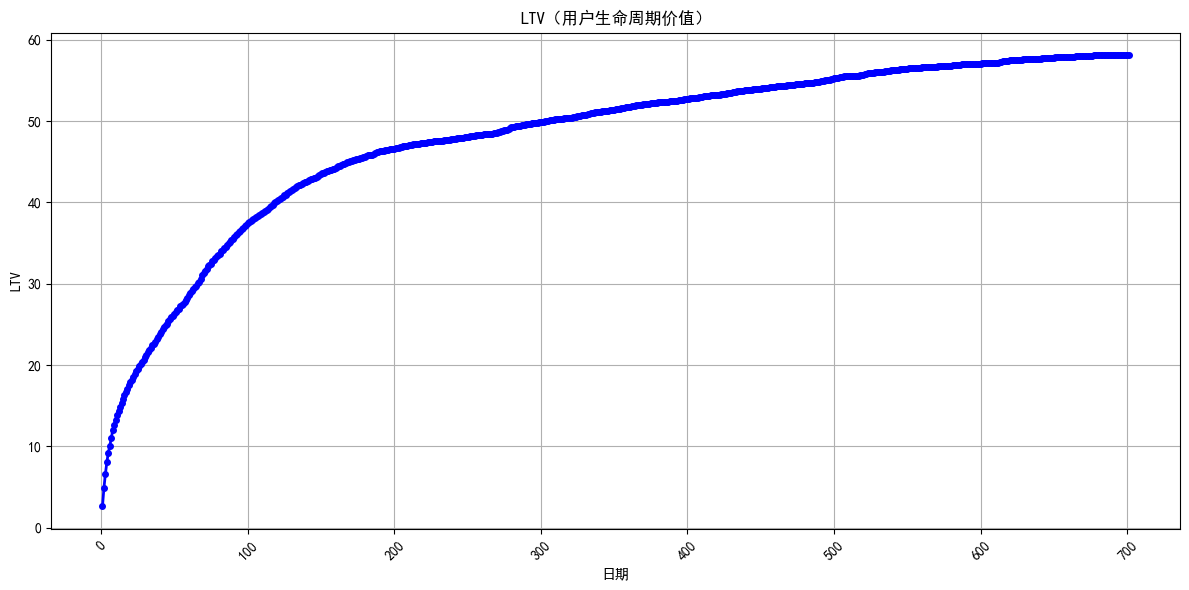

In [16]:
#汇制ltv_values_cum
plt.figure(figsize=(12, 6))
ltv_values_cum.plot(kind='line', 
grid=True,
title="LTV（用户生命周期价值）",
linewidth=2,
color='blue',
marker='o',
markersize=4)
# plt.gca().yaxis.set_major_formatter(FuncFormatter(to_percent))       #把y轴格式化为百分比形式
# plt.yscale('log')  # 设置Y轴为对数刻度
plt.ylabel('LTV')
plt.xlabel('日期')
plt.xticks(rotation=45)  # 旋转x轴标签
plt.tight_layout()
plt.show()

In [17]:
#汇总每个用户的online_time_sec 和 real_money
user_summary = login_filter.groupby('rid').agg({
    'online_time_sec': 'sum',
    'real_money': 'sum'
}).reset_index()
print("每个用户的在线时长和充值金额汇总:")
print(user_summary.head(5))

每个用户的在线时长和充值金额汇总:
                  rid  online_time_sec  real_money
0  R13107717024835251             22.0         0.0
1  R13107717024835331             15.0         0.0
2  R13107717024835541             41.0         0.0
3  R13107717024835731             46.0         0.0
4  R13107717024835851             34.0         0.0


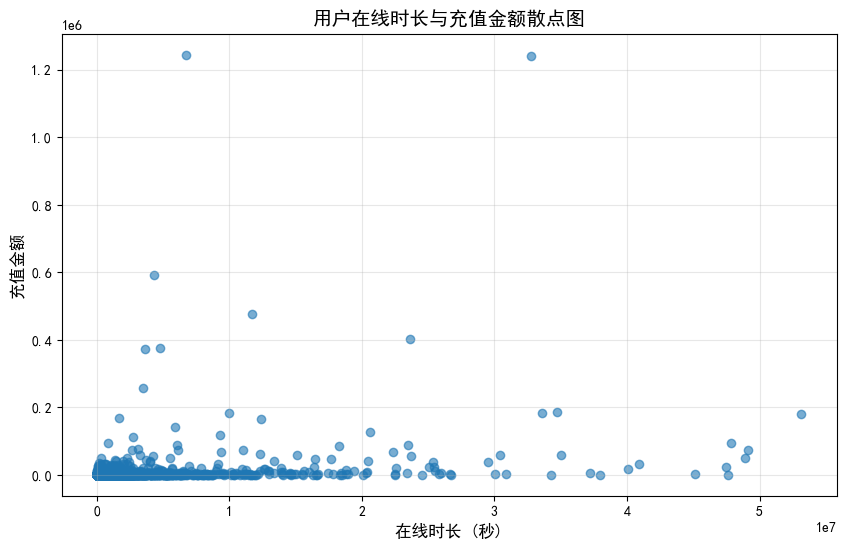

In [18]:
#画出在线时长和充值金额的散点图
plt.figure(figsize=(10, 6))
plt.scatter(user_summary['online_time_sec'], user_summary['real_money'], alpha=0.6)
plt.title('用户在线时长与充值金额散点图', fontsize=14, fontweight='bold')
plt.xlabel('在线时长 (秒)', fontsize=12)
plt.ylabel('充值金额', fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()